In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import re 

# 경로 설정
wbt_directory = '/home/piai/DDPM_STE_GSL/Webots_worlds/outputs4/'
output_directory_map1 = '/home/piai/DDPM_STE_GSL/Feature_map/map1/outputs8'
output_directory_map2 = '/home/piai/DDPM_STE_GSL/Feature_map/map2/outputs8'
output_directory_map3 = '/home/piai/DDPM_STE_GSL/Feature_map/map3/outputs8'

# 폴더 생성
os.makedirs(output_directory_map1, exist_ok=True)
os.makedirs(output_directory_map2, exist_ok=True)
os.makedirs(output_directory_map3, exist_ok=True)

MAP_SIZE = 64  # 64x64 셀 크기

# 문(Door)의 고정된 입구와 출구 위치
inlet_pos = (-3.35782, -2.05932)  # Door 위치를 고정된 입구 좌표로 사용
outlet_pos = (3.33907, 2.13303)  # Door 위치를 고정된 출구 좌표로 사용

def create_feature_maps(wbt_file_path, gas_source_pos):
    """wbt 파일을 읽고 map1(속성), map2(SDF), map3(Inverse Distance)를 생성하는 함수"""
    
    map1 = np.ones((MAP_SIZE, MAP_SIZE))  # 각 셀의 속성 맵 초기화 (빈 공간을 1로 설정)
    map2 = np.zeros((MAP_SIZE, MAP_SIZE))  # SDF 맵 초기화
    map3 = np.zeros((MAP_SIZE, MAP_SIZE))  # Inverse Distance 맵 초기화
    
    # 장애물(WoodenBox)와 문(Door)의 위치 및 크기 정보를 가져오기
    with open(wbt_file_path, 'r') as file:
        content = file.read()
        
        # WoodenBox의 위치 및 크기 정보 추출 (translation 및 size)
        boxes = re.findall(r'WoodenBox\s*\{\s*translation\s*([-.\d]+)\s+([-.\d]+)\s+([-.\d]+)\s*size\s*([-.\d]+)\s+([-.\d]+)\s+([-.\d]+)', content)
        # Door의 위치 및 크기 정보 추출 (translation 및 size)
        doors = re.findall(r'Door\s*\{\s*translation\s*([-.\d]+)\s+([-.\d]+)\s+([-.\d]+)\s*size\s*([-.\d]+)\s+([-.\d]+)\s+([-.\d]+)', content)
        
        # 장애물(WoodenBox)의 위치와 크기를 그리드 상에 반영
        for box in boxes:
            x, y, z, size_x, size_y, size_z = map(float, box)
            
            # 장애물 위치 및 크기를 64x64 그리드로 변환
            grid_x = int((x + 3.5) * (MAP_SIZE / 7.0))  # x 좌표를 그리드 셀에 맞춤
            grid_y = int((y + 3.5) * (MAP_SIZE / 7.0))  # y 좌표를 그리드 셀에 맞춤
            
            size_grid_x = int(size_x * (MAP_SIZE / 7.0))  # 장애물 가로 크기 반영
            size_grid_y = int(size_y * (MAP_SIZE / 7.0))  # 장애물 세로 크기 반영
            
            # 장애물에 대해 그리드 상에 0으로 라벨링
            for i in range(grid_x, grid_x + size_grid_x):
                for j in range(grid_y, grid_y + size_grid_y):
                    if 0 <= i < MAP_SIZE and 0 <= j < MAP_SIZE:
                        map1[i, j] = 0  # 장애물은 0으로 설정

        # 문(Door)의 위치와 크기를 그리드 상에 반영
        for door in doors:
            x, y, z, size_x, size_y, size_z = map(float, door)
            
            # 문 위치 및 크기를 64x64 그리드로 변환
            grid_x = int((x + 3.5) * (MAP_SIZE / 7.0))
            grid_y = int((y + 3.5) * (MAP_SIZE / 7.0))
            
            size_grid_x = int(size_x * (MAP_SIZE / 7.0))
            size_grid_y = int(size_y * (MAP_SIZE / 7.0))
            
            # 문에 대해 그리드 상에 입구(3) 또는 출구(4)로 라벨링
            for i in range(grid_x, grid_x + size_grid_x):
                for j in range(grid_y, grid_y + size_grid_y):
                    if 0 <= i < MAP_SIZE and 0 <= j < MAP_SIZE:
                        if (x, y) == inlet_pos:
                            map1[i, j] = 3  # 입구는 3으로 설정
                        elif (x, y) == outlet_pos:
                            map1[i, j] = 4  # 출구는 4로 설정

    # 빈 공간 및 객체로부터의 거리를 계산하는 SDF 맵 생성
    sdf_positive = distance_transform_edt(map1 != 0)  # 빈 공간에서 객체까지 거리
    sdf_negative = distance_transform_edt(map1 == 0)  # 객체 내부에서 음수 거리
    map2 = sdf_positive  # 빈 공간의 SDF 저장
    map2[map1 == 0] = -sdf_negative[map1 == 0]  # 객체 내부는 음수로 설정
    
    # 가스 소스에서 각 셀까지의 거리를 역수로 변환 (Inverse Distance 맵 생성)
    gas_source_x, gas_source_y = gas_source_pos
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            dist = np.sqrt((i - gas_source_x) ** 2 + (j - gas_source_y) ** 2)
            map3[i, j] = 1 / dist if dist > 0 else 0  # 거리가 0이면 제외하고, 역수로 설정
    
    return map1, map2, map3

def save_feature_maps(map1, map2, map3, wbt_file_name):
    """Feature Map을 각각의 폴더에 저장하는 함수"""
    base_name = os.path.splitext(wbt_file_name)[0]  # 파일 이름에서 확장자 제거
    np.save(os.path.join(output_directory_map1, f'{base_name}_map1.npy'), map1)
    np.save(os.path.join(output_directory_map2, f'{base_name}_map2.npy'), map2)
    np.save(os.path.join(output_directory_map3, f'{base_name}_map3.npy'), map3)

def process_wbt_files():
    """모든 wbt 파일을 처리하여 Feature Map을 생성하는 함수"""
    files = [f for f in os.listdir(wbt_directory) if f.endswith('.wbt')]

    for wbt_file in files:
        wbt_file_path = os.path.join(wbt_directory, wbt_file)
        print(f"Processing {wbt_file}...")

        # 가스 소스 위치는 임의로 설정
        gas_source_pos = (np.random.randint(0, MAP_SIZE), np.random.randint(0, MAP_SIZE))  # 가스 소스는 임의의 위치

        # Feature Map 생성
        map1, map2, map3 = create_feature_maps(wbt_file_path, gas_source_pos)

        # Feature Map 저장
        save_feature_maps(map1, map2, map3, wbt_file)


# wbt 파일 처리 및 Feature Map 생성 및 저장
process_wbt_files()

Processing output_world_176.wbt...
Processing output_world_164.wbt...
Processing output_world_151.wbt...
Processing output_world_154.wbt...
Processing output_world_17.wbt...
Processing output_world_120.wbt...
Processing output_world_57.wbt...
Processing output_world_116.wbt...
Processing output_world_99.wbt...
Processing output_world_200.wbt...
Processing output_world_166.wbt...
Processing output_world_38.wbt...
Processing output_world_55.wbt...
Processing output_world_193.wbt...
Processing output_world_134.wbt...
Processing output_world_162.wbt...
Processing output_world_70.wbt...
Processing output_world_121.wbt...
Processing output_world_159.wbt...
Processing output_world_136.wbt...
Processing output_world_150.wbt...
Processing output_world_51.wbt...
Processing output_world_145.wbt...
Processing output_world_163.wbt...
Processing output_world_195.wbt...
Processing output_world_73.wbt...
Processing output_world_144.wbt...
Processing output_world_124.wbt...
Processing output_world_123.

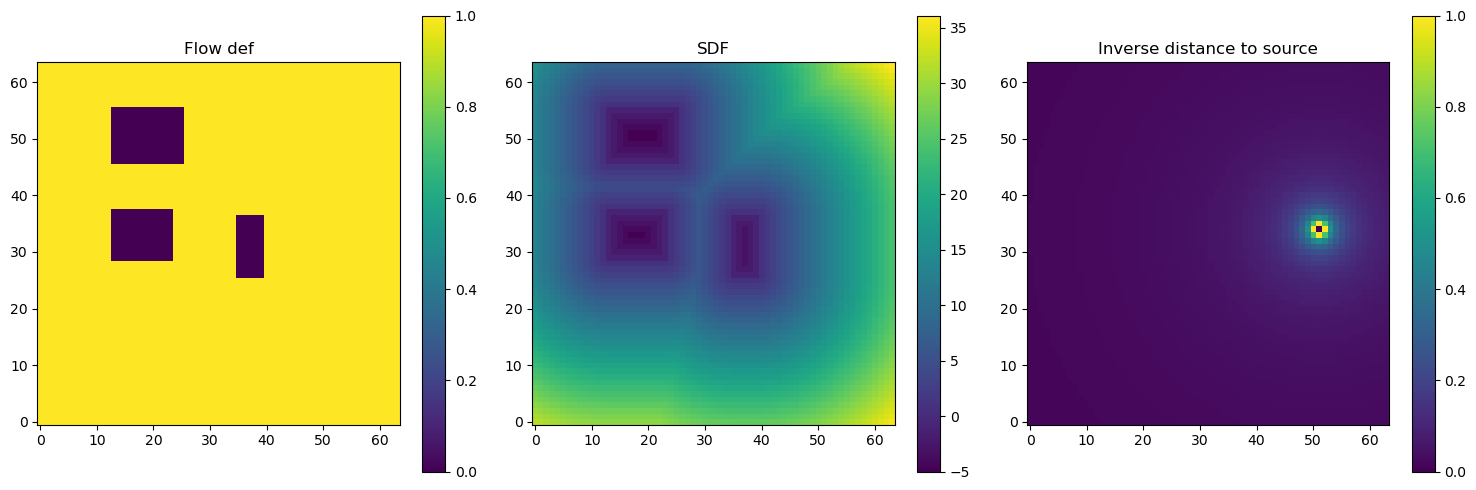

In [35]:
def visualize_feature_maps(map1, map2, map3):
    """세 가지 Feature Map을 시각화하는 함수"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Flow Definition Map 시각화
    im1 = axs[0].imshow(map1, cmap='viridis', origin='lower')
    axs[0].set_title('Flow def')
    fig.colorbar(im1, ax=axs[0])

    # SDF Map 시각화
    im2 = axs[1].imshow(map2, cmap='viridis', origin='lower')
    axs[1].set_title('SDF')
    fig.colorbar(im2, ax=axs[1])

    # Inverse Distance Map 시각화
    im3 = axs[2].imshow(map3, cmap='viridis', origin='lower')
    axs[2].set_title('Inverse distance to source')
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout()
    plt.show()

# world 1에 대한 Feature Map 시각화
map1 = np.load('/home/piai/DDPM_STE_GSL/Feature_map/map1/outputs7/output_world_200_map1.npy')
map2 = np.load('/home/piai/DDPM_STE_GSL/Feature_map/map2/outputs7/output_world_200_map2.npy')
map3 = np.load('/home/piai/DDPM_STE_GSL/Feature_map/map3/outputs7/output_world_200_map3.npy')

# world 1의 Feature Map 시각화
visualize_feature_maps(map1, map2, map3)